In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
from pathlib import Path
import random
from sklearn.preprocessing import LabelEncoder



Total training images found: 1938
Unique training classes found: 11
Total test images found: 502
Unique test classes found: 11


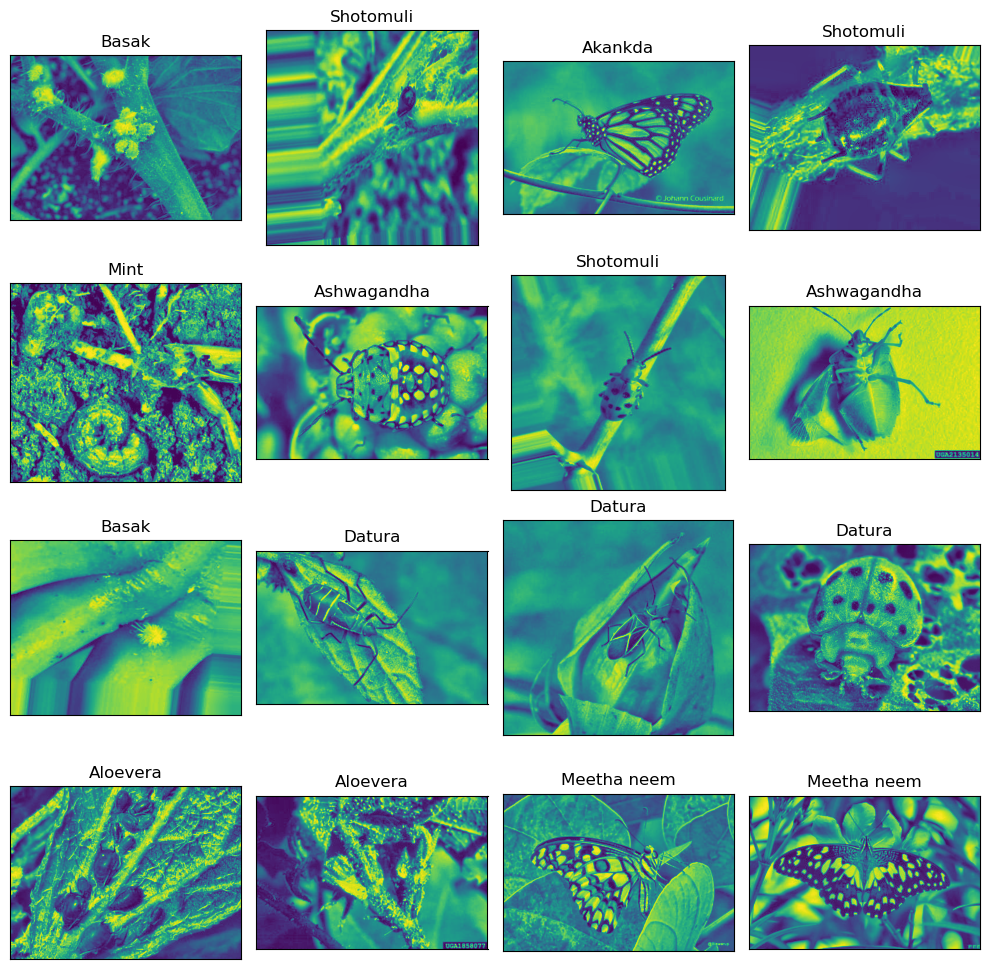

Found 1512 validated image filenames belonging to 11 classes.
Found 500 validated image filenames belonging to 11 classes.


C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 48 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [16]:
# Define the directories as Path objects
train_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train")
test_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\test")


# Function to load images and labels
def load_data(data_path):
    filepaths = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG','*.webp','*.WEBP']:
        filepaths.extend(list(data_path.rglob(ext)))  # rglob works with Path objects
    labels = [os.path.split(os.path.split(str(path))[0])[1] for path in filepaths]
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df


# Load the training and test data
train_image_df = load_data(train_dir)
test_image_df = load_data(test_dir)

print(f"Total training images found: {len(train_image_df)}")
print(f"Unique training classes found: {train_image_df['Label'].nunique()}")
print(f"Total test images found: {len(test_image_df)}")
print(f"Unique test classes found: {test_image_df['Label'].nunique()}")




label_encoder = LabelEncoder()

# Fit and transform training labels
train_image_df['Encoded_Label'] = label_encoder.fit_transform(train_image_df['Label'])

# Transform test labels using the same encoder
test_image_df['Encoded_Label'] = label_encoder.transform(test_image_df['Label'])


num_classes = len(label_encoder.classes_)


random_index = np.random.randint(0, len(train_image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    img = plt.imread(train_image_df.Filepath.iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(train_image_df.Label.iloc[random_index[i]])  
plt.tight_layout()
plt.show()


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = datagen.flow_from_dataframe(
    train_image_df,
    x_col='Filepath',
    y_col='Label',  
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_image_df,
    x_col='Filepath',
    y_col='Label',  
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.15,        
    zoom_range=0.2,           
    horizontal_flip=True,    
    vertical_flip=True,       
    fill_mode="nearest",    
    validation_split=0.2     
)


train_generator = datagen.flow_from_dataframe(
    train_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training'
)



test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 1512 validated image filenames belonging to 11 classes.
Found 500 validated image filenames belonging to 11 classes.


C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 48 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Apollo Gadget\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


CLAHE

Displaying CLAHE-enhanced image from: C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train\Akankda\032478c96d184737991d2a0b1765c4cf.webp


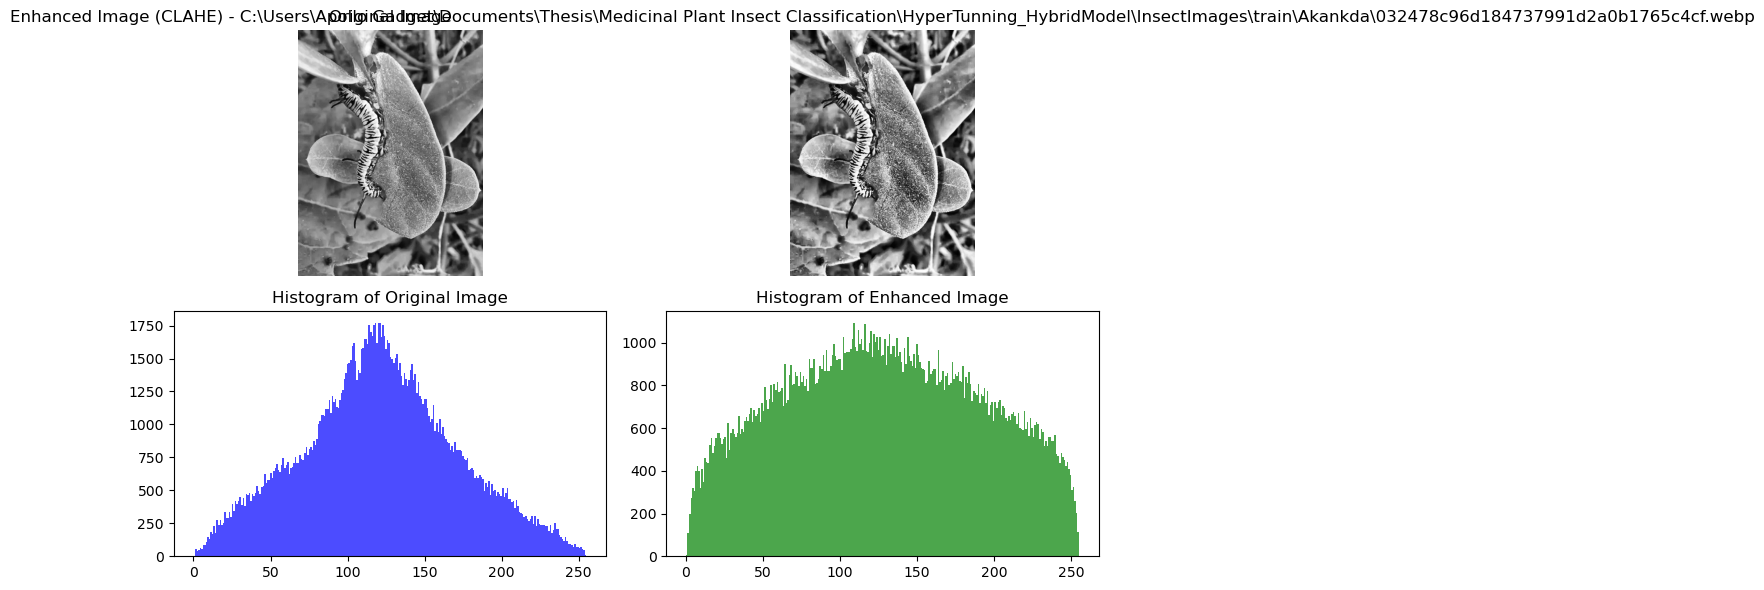

In [18]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Function to apply CLAHE enhancement to an image array
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Function to apply CLAHE to all images in a directory and overwrite them
def enhance_train_images(input_dir):
    all_images = []
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    clahe_image = apply_clahe(img)
                    cv2.imwrite(image_path, clahe_image)  # Overwrite the original image
                    all_images.append((img, clahe_image, image_path))  # Save paths with images for selection
                else:
                    print(f"Warning: Could not read image {image_path}")
    return all_images

# Function to display an image and its histogram
def display_image_and_histogram(original, enhanced, title=""):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))
    
    # Original image
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    
    # Histogram of original image
    axes[1, 0].hist(original.ravel(), bins=256, color='blue', alpha=0.7)
    axes[1, 0].set_title("Histogram of Original Image")
    
    # Enhanced image
    axes[0, 1].imshow(enhanced, cmap='gray')
    axes[0, 1].set_title(f"Enhanced Image (CLAHE) - {title}")
    axes[0, 1].axis('off')
    
    # Histogram of enhanced image
    axes[1, 1].hist(enhanced.ravel(), bins=256, color='green', alpha=0.7)
    axes[1, 1].set_title("Histogram of Enhanced Image")
    
    plt.tight_layout()
    plt.show()

# Define training directory
train_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train")

# Enhance training images with CLAHE directly in original folders
enhanced_train_images = enhance_train_images(train_dir)

# Display a specific image and its histogram (e.g., the first image in the list)
if enhanced_train_images:
    original_img, enhanced_img, img_path = enhanced_train_images[1]  # Change index to select another image if desired
    print(f"Displaying CLAHE-enhanced image from: {img_path}")
    display_image_and_histogram(original_img, enhanced_img, title=img_path)
else:
    print("No images found for enhancement.")


VGG16

In [19]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Redefine the directories as Path objects
train_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\train")
test_dir = Path(r"C:\Users\Apollo Gadget\Documents\Thesis\Medicinal Plant Insect Classification\HyperTunning_HybridModel\InsectImages\test")

# Function to load images and labels
def load_data(data_path):
    filepaths = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG', '*.webp', '*.WEBP']:
        filepaths.extend(list(data_path.rglob(ext)))  # rglob works with Path objects
    labels = [os.path.split(os.path.split(str(path))[0])[1] for path in filepaths]
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

# Function to load the VGG16 model for feature extraction
def load_cnn_model(input_shape=(224, 224, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Model(inputs=base_model.input, outputs=base_model.output)
    return model

# Function to preprocess and load a single image
def load_image(filepath, target_size=(224, 224)):
    img = load_img(filepath, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to match VGG16 input scale
    return img_array

# Function to extract features from the VGG model
def extract_features_from_vgg(image_df, model):
    features = []
    for filepath in image_df['Filepath']:
        img = load_image(filepath)
        feature = model.predict(img)
        features.append(feature.flatten())
    return np.array(features)

# Load the data
image_df = load_data(train_dir)  # Load your dataset

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    image_df['Filepath'], 
    image_df['Label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=image_df['Label']
)

# Create DataFrames for training and validation
train_image_df = pd.DataFrame({'Filepath': X_train, 'Label': y_train})
val_image_df = pd.DataFrame({'Filepath': X_val, 'Label': y_val})

# Label encoding
label_encoder = LabelEncoder()
train_image_df['Encoded_Label'] = label_encoder.fit_transform(train_image_df['Label'])
val_image_df['Encoded_Label'] = label_encoder.transform(val_image_df['Label'])

# Load VGG16 model
vgg_model = load_cnn_model()

# Extract features for the training and validation sets
X_train_vgg = extract_features_from_vgg(train_image_df, vgg_model)
X_val_vgg = extract_features_from_vgg(val_image_df, vgg_model)

# Standardize the features
scaler = StandardScaler()
X_train_vgg = scaler.fit_transform(X_train_vgg)
X_val_vgg = scaler.transform(X_val_vgg)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_vgg_resampled, y_train_resampled = smote.fit_resample(X_train_vgg, train_image_df['Encoded_Label'].values)

# Display the resampled shapes
print(f"Resampled training features shape: {X_train_vgg_resampled.shape}")
print(f"Resampled training labels shape: {y_train_resampled.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


clf_svm = SVC(kernel='rbf', random_state=42, max_iter=1000)

# Train the SVM model using the resampled training data
clf_svm.fit(X_train_vgg_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_svm = clf_svm.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_svm)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print the confusion matrix
confusion = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_svm)
print("\nConfusion Matrix:\n", confusion)

# Print detailed classification report
report = classification_report(val_image_df['Encoded_Label'].values, y_pred_svm, 
                               target_names=label_encoder.classes_)
print("\nClassification Report:\n", report)


Accuracy: 95.10%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  2  0  0  0  0]
 [ 0  1 39  0  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  2  0  0  0  0]
 [ 0  0  0  0 34  0  2  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  2  0  0  0  0  0 33  0  0  0]
 [ 0  4  0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  2  0  0 25  0]
 [ 0  0  0  0  0  0  4  0  0  0 25]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       0.84      0.95      0.89        40
 Ashwagandha       1.00      0.97      0.99        40
       Basak       1.00      0.95      0.97        37
      Datura       1.00      0.94      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       0.74      1.00      0.85        34
        Mint       1.00      0.94      0.97        35
      Pudina       1.00      0.89      0.94        36


SVM with HyperTunning

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


param_grid = {
    'kernel': ['linear','rbf', 'sigmoid'],
    'max_iter': [1000,1100]
}
svm = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=2, scoring='accuracy')


grid_search.fit(X_train_vgg_resampled, y_train_resampled)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_svm = SVC(**best_params, random_state=42)
best_svm.fit(X_train_vgg_resampled, y_train_resampled)

y_pred_svm = best_svm.predict(X_val_vgg)
val_accuracy = accuracy_score(val_image_df['Encoded_Label'],y_pred_svm)
print("SVM Accuracy with Tuned Hyperparameters:", val_accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(val_image_df['Encoded_Label'],y_pred_svm)


# Classification report
print("Classification Report (Validation):")
print(classification_report(val_image_df['Encoded_Label'], y_pred_svm, target_names=label_encoder.classes_))





Best Hyperparameters: {'kernel': 'linear', 'max_iter': 1000}
SVM Accuracy with Tuned Hyperparameters: 0.9639175257731959
Classification Report (Validation):
              precision    recall  f1-score   support

     Akankda       0.95      1.00      0.98        40
    Aloevera       0.83      0.95      0.88        40
 Ashwagandha       1.00      1.00      1.00        40
       Basak       0.95      0.95      0.95        37
      Datura       0.95      1.00      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       1.00      1.00      1.00        34
        Mint       1.00      0.94      0.97        35
      Pudina       1.00      0.89      0.94        36
   Shotomuli       1.00      0.93      0.96        27
    Thankuni       1.00      0.93      0.96        29

    accuracy                           0.96       388
   macro avg       0.97      0.96      0.97       388
weighted avg       0.97      0.96      0.96       388



RF

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model using the resampled training data
rf_classifier.fit(X_train_vgg_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_rf = rf_classifier.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy_rf = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_rf)
print(f"Accuracy of Random Forest: {accuracy_rf * 100:.2f}%")

# Print the confusion matrix
confusion_rf = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_rf)
print("\nConfusion Matrix:\n", confusion_rf)

# Print detailed classification report
report_rf = classification_report(val_image_df['Encoded_Label'].values, y_pred_rf, 
                                  target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_rf)


Accuracy of Random Forest: 94.85%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  2  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  0  0  2]
 [ 0  0  0  0 34  0  0  0  0  0  2]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  2]
 [ 0  2  0  0  0  0  0  0 34  0  0]
 [ 0  0  2  0  2  0  0  0  0 23  0]
 [ 0  2  0  4  0  0  0  0  0  0 23]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       0.90      0.95      0.93        40
 Ashwagandha       0.91      1.00      0.95        40
       Basak       0.90      0.95      0.92        37
      Datura       0.94      0.94      0.94        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       1.00      1.00      1.00        34
        Mint       1.00      0.94      0.97        35
      Pudina       1.00      0.94    

RF with hyperparameter tunning

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the hyperparameter grid for Random Forest, including n_estimators=100
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Added 100 to the list
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV to find the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=2, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the resampled training data
grid_search_rf.fit(X_train_vgg_resampled, y_train_resampled)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest Classifier:", best_params_rf)

# Train a new Random Forest model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf.fit(X_train_vgg_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_rf = best_rf.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy_rf = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_rf)
print(f"Random Forest Classifier Accuracy with Tuned Hyperparameters: {accuracy_rf * 100:.2f}%")

# Print the confusion matrix
confusion_rf = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_rf)
print("\nConfusion Matrix:\n", confusion_rf)

# Print detailed classification report
report_rf = classification_report(val_image_df['Encoded_Label'].values, y_pred_rf, 
                                  target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_rf)


Best Hyperparameters for Random Forest Classifier: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Classifier Accuracy with Tuned Hyperparameters: 95.88%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  2  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  0  2  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  2  0  0]
 [ 0  4  0  0  0  0  0  0 32  0  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  0  0  4  0  0  0  0  0  0 25]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       0.90      0.95      0.93        40
 Ashwagandha       0.95      1.00      0.98        40
       Basak       0.85      0.95      0.90        37
      Datura       1.00      1.00      1.00        36
     Isabgol       1.00    

KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors

# Train the KNN model using the resampled training data
knn_classifier.fit(X_train_vgg_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_knn = knn_classifier.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy_knn = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_knn)
print(f"Accuracy of KNN: {accuracy_knn * 100:.2f}%")

# Print the confusion matrix
confusion_knn = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_knn)
print("\nConfusion Matrix:\n", confusion_knn)

# Print detailed classification report
report_knn = classification_report(val_image_df['Encoded_Label'].values, y_pred_knn, 
                                    target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_knn)


Accuracy of KNN: 69.33%

Confusion Matrix:
 [[31  0  0  0  0  0  0  2  0  2  5]
 [ 0 28  0  5  0  0  1  2  0  0  4]
 [ 0  1 17  1  0  2  0  3  0  4 12]
 [ 0  0  0 20  0  0  0  2  0  0 15]
 [ 0  2  0  2 25  0  1  0  0  0  6]
 [ 0  1  0  0  0 27  0  0  0  0  6]
 [ 0  0  0  1  0  0 23  0  0  2  8]
 [ 0  0  0  0  0  0  1 30  0  0  4]
 [ 0  1  0  3  0  0  0  4 26  0  2]
 [ 0  0  0  2  0  0  0  7  0 18  0]
 [ 0  1  0  4  0  0  0  0  0  0 24]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      0.78      0.87        40
    Aloevera       0.82      0.70      0.76        40
 Ashwagandha       1.00      0.42      0.60        40
       Basak       0.53      0.54      0.53        37
      Datura       1.00      0.69      0.82        36
     Isabgol       0.93      0.79      0.86        34
 Meetha neem       0.88      0.68      0.77        34
        Mint       0.60      0.86      0.71        35
      Pudina       1.00      0.72      0.84    

In [ ]:
KNN Hyperparameter

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the hyperparameter grid, including n_neighbors=5
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Ensures 5 is included
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # For different distance metrics (1 = Manhattan, 2 = Euclidean)
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV to find the best hyperparameters
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=2, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the resampled training data
grid_search_knn.fit(X_train_vgg_resampled, y_train_resampled)

# Get the best hyperparameters
best_params_knn = grid_search_knn.best_params_
print("Best Hyperparameters for KNN Classifier:", best_params_knn)

# Train a new KNN model with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(X_train_vgg_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_knn = best_knn.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy_knn = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_knn)
print(f"KNN Classifier Accuracy with Tuned Hyperparameters: {accuracy_knn * 100:.2f}%")

# Print the confusion matrix
confusion_knn = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_knn)
print("\nConfusion Matrix:\n", confusion_knn)

# Print detailed classification report
report_knn = classification_report(val_image_df['Encoded_Label'].values, y_pred_knn, 
                                    target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_knn)


Best Hyperparameters for KNN Classifier: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN Classifier Accuracy with Tuned Hyperparameters: 95.36%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  2]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  2  0 35  0  0  0  0  0  0  0]
 [ 0  2  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 2  0  0  0  0  0 32  0  0  0  0]
 [ 0  2  0  0  0  0  0 33  0  0  0]
 [ 0  0  0  4  0  0  0  0 32  0  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  0  0  2  0  0  0  0  0  0 27]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       0.95      1.00      0.98        40
    Aloevera       0.86      0.95      0.90        40
 Ashwagandha       1.00      1.00      1.00        40
       Basak       0.81      0.95      0.88        37
      Datura       1.00      0.94      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       1.00      

NB

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the Naive Bayes model using the resampled training data
nb_classifier.fit(X_train_vgg_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_nb = nb_classifier.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy_nb = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_nb)
print(f"Accuracy of Naive Bayes: {accuracy_nb * 100:.2f}%")

# Print the confusion matrix
confusion_nb = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_nb)
print("\nConfusion Matrix:\n", confusion_nb)

# Print detailed classification report
report_nb = classification_report(val_image_df['Encoded_Label'].values, y_pred_nb, 
                                   target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_nb)


Accuracy of Naive Bayes: 93.81%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 2 38  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  2  0 35  0  0  0  0  0  0  0]
 [ 2  0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  2]
 [ 0  0  2  2  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  4  0  0 23  0]
 [ 0  0  0  4  0  0  0  2  0  2 21]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       0.91      1.00      0.95        40
    Aloevera       0.95      0.95      0.95        40
 Ashwagandha       0.95      1.00      0.98        40
       Basak       0.85      0.95      0.90        37
      Datura       1.00      0.94      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       0.89      1.00      0.94        34
        Mint       0.94      0.94      0.94        35
      Pudina       1.00      0.89      

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the hyperparameter grid for Naive Bayes
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize the Gaussian Naive Bayes classifier
nb = GaussianNB()

# Create a GridSearchCV object to find the best hyperparameters
grid_search_nb = GridSearchCV(estimator=nb, param_grid=param_grid_nb, cv=2, scoring='accuracy', n_jobs=-1)

# Fit the grid search to your training data
grid_search_nb.fit(X_train_vgg_resampled, y_train_resampled)

# Get the best hyperparameters
best_params_nb = grid_search_nb.best_params_
print("Best Hyperparameters for Naive Bayes Classifier:", best_params_nb)

# Train a new Naive Bayes model with the best hyperparameters
best_nb = GaussianNB(**best_params_nb)
best_nb.fit(X_train_vgg_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_nb_tuned = best_nb.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy_nb_tuned = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_nb_tuned)
print(f"Accuracy of Naive Bayes with Tuned Hyperparameters: {accuracy_nb_tuned * 100:.2f}%")

# Print the confusion matrix
confusion_nb_tuned = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_nb_tuned)
print("\nConfusion Matrix:\n", confusion_nb_tuned)

# Print detailed classification report
report_nb_tuned = classification_report(val_image_df['Encoded_Label'].values, y_pred_nb_tuned, 
                                        target_names=label_encoder.classes_)
print("\nClassification Report:\n", report_nb_tuned)


Best Hyperparameters for Naive Bayes Classifier: {'var_smoothing': 1e-07}
Accuracy of Naive Bayes with Tuned Hyperparameters: 93.81%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 2 38  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  2  0 35  0  0  0  0  0  0  0]
 [ 2  0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  0  2]
 [ 0  0  2  2  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  4  0  0 23  0]
 [ 0  0  0  4  0  0  0  2  0  2 21]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       0.91      1.00      0.95        40
    Aloevera       0.95      0.95      0.95        40
 Ashwagandha       0.95      1.00      0.98        40
       Basak       0.85      0.95      0.90        37
      Datura       1.00      0.94      0.97        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       0.89      1.00      0.94   

MLP

In [28]:
from sklearn.neural_network import MLPClassifier


mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  
    activation='relu',              
    solver='adam',                 
    max_iter=1000,                  
    random_state=42,                 
    early_stopping=True,             
    validation_fraction=0.1      
)

# Train MLP on the resampled training data
mlp_model.fit(X_train_vgg_resampled, y_train_resampled)

# Predict on the validation/test set
y_pred_mlp = mlp_model.predict(X_val_vgg) 

# Evaluate MLP accuracy
mlp_accuracy = accuracy_score(val_image_df['Encoded_Label'], y_pred_mlp)
print(f"\nMLP Accuracy: {mlp_accuracy:.4f}")

# Confusion matrix and classification report
mlp_confusion = confusion_matrix(val_image_df['Encoded_Label'], y_pred_mlp)
mlp_report = classification_report(val_image_df['Encoded_Label'], y_pred_mlp,
                                   target_names=label_encoder.classes_)

print("\nMLP Confusion Matrix:\n", mlp_confusion)
print("\nMLP Classification Report:\n", mlp_report)



MLP Accuracy: 0.9330

MLP Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  2  0  0  0]
 [ 0  1 39  0  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  3  0  0 31  0  0  0  0  0]
 [ 1  0  0  0  0  0 33  0  0  0  0]
 [ 0  2  0  0  0  1  0 32  0  0  0]
 [ 0  2  0  2  0  0  0  0 32  0  0]
 [ 0  0  0  2  0  0  2  0  0 23  0]
 [ 0  0  0  4  2  0  0  0  0  2 21]]

MLP Classification Report:
               precision    recall  f1-score   support

     Akankda       0.98      1.00      0.99        40
    Aloevera       0.88      0.95      0.92        40
 Ashwagandha       0.93      0.97      0.95        40
       Basak       0.82      1.00      0.90        37
      Datura       0.95      1.00      0.97        36
     Isabgol       0.97      0.91      0.94        34
 Meetha neem       0.94      0.97      0.96        34
        Mint       0.94      0.91      0.93        35
      Pudina       1.00      0.89      0.

In [ ]:
MLP hyperparameter

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the hyperparameter grid for MLP Classifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 100)],
    'activation': ['relu', 'logistic'],
    'alpha': [0.001, 0.01],
    'learning_rate_init': [0.01, 0.1]
}

# Create an instance of the MLP Classifier
mlp = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, validation_fraction=0.1)

# Create a GridSearchCV object to find the best hyperparameters
grid_search_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=2, scoring='accuracy', n_jobs=-1)

# Fit the grid search to your resampled training data
grid_search_mlp.fit(X_train_vgg_resampled, y_train_resampled)

# Get the best hyperparameters
best_params_mlp = grid_search_mlp.best_params_
print("Best Hyperparameters for MLP Classifier:", best_params_mlp)

# Train a new MLP model with the best hyperparameters
best_mlp = MLPClassifier(**best_params_mlp, random_state=42, max_iter=1000, early_stopping=True, validation_fraction=0.1)
best_mlp.fit(X_train_vgg_resampled, y_train_resampled)

# Predict on the validation set
y_pred_mlp_tuned = best_mlp.predict(X_val_vgg)

# Calculate and print the accuracy
accuracy_mlp_tuned = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_mlp_tuned)
print(f"\nMLP Classifier Accuracy with Tuned Hyperparameters: {accuracy_mlp_tuned:.4f}")

# Print the confusion matrix
mlp_confusion_tuned = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_mlp_tuned)
print("\nMLP Confusion Matrix with Tuned Hyperparameters:\n", mlp_confusion_tuned)

# Print detailed classification report
mlp_report_tuned = classification_report(val_image_df['Encoded_Label'].values, y_pred_mlp_tuned, 
                                         target_names=label_encoder.classes_)
print("\nMLP Classification Report with Tuned Hyperparameters:\n", mlp_report_tuned)


Best Hyperparameters for MLP Classifier: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}

MLP Classifier Accuracy with Tuned Hyperparameters: 0.9149

MLP Confusion Matrix with Tuned Hyperparameters:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 2 38  0  0  0  0  0  0  0  0  0]
 [ 0  1 38  0  1  0  0  0  0  0  0]
 [ 0  1  0 34  0  0  2  0  0  0  0]
 [ 0  0  0  0 34  1  1  0  0  0  0]
 [ 0  0  0  3  0 30  0  0  1  0  0]
 [ 1  0  1  0  0  0 31  1  0  0  0]
 [ 0  2  0  0  0  0  0 33  0  0  0]
 [ 0  2  0  0  0  0  0  0 32  2  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  2  0  4  0  1  0  0  0  2 20]]

MLP Classification Report with Tuned Hyperparameters:
               precision    recall  f1-score   support

     Akankda       0.93      1.00      0.96        40
    Aloevera       0.83      0.95      0.88        40
 Ashwagandha       0.97      0.95      0.96        40
       Basak       0.79      0.92      0.85        37
      Datura       0.9

ExtraTree

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)


extra_trees_model.fit(X_train_vgg_resampled, y_train_resampled)

y_pred_extra_trees = extra_trees_model.predict(X_val_vgg)


extra_trees_accuracy = accuracy_score(val_image_df['Encoded_Label'], y_pred_extra_trees)
print(f"\nExtra Trees Accuracy: {extra_trees_accuracy:.4f}")

extra_trees_confusion = confusion_matrix(val_image_df['Encoded_Label'], y_pred_extra_trees)
extra_trees_report = classification_report(val_image_df['Encoded_Label'], y_pred_extra_trees,
                                           target_names=label_encoder.classes_)

print("\nExtra Trees Confusion Matrix:\n", extra_trees_confusion)
print("\nExtra Trees Classification Report:\n", extra_trees_report)



Extra Trees Accuracy: 0.9639

Extra Trees Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  2  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0  0  2  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  2  0  0  0  0  0 33  0  0  0]
 [ 0  4  0  0  0  0  0  0 32  0  0]
 [ 0  0  2  2  0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0  0  0  0  0 29]]

Extra Trees Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       0.86      0.95      0.90        40
 Ashwagandha       0.91      1.00      0.95        40
       Basak       0.95      0.95      0.95        37
      Datura       1.00      1.00      1.00        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       1.00      1.00      1.00        34
        Mint       1.00      0.94      0.97        35
      Pudina     

ExtraTree hyperparameter

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the hyperparameter grid for Extra Trees Classifier, excluding 'n_estimators'
param_grid_et = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

# Create an instance of the Extra Trees Classifier without specifying 'n_estimators'
et = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Create a GridSearchCV object to find the best hyperparameters
grid_search_et = GridSearchCV(estimator=et, param_grid=param_grid_et, cv=2, scoring='accuracy', n_jobs=-1)

# Fit the grid search to your resampled training data
grid_search_et.fit(X_train_vgg_resampled, y_train_resampled)

# Get the best hyperparameters (excluding 'n_estimators' as we fixed it at 100)
best_params_et = grid_search_et.best_params_
print("Best Hyperparameters for Extra Trees Classifier:", best_params_et)

# Train a new Extra Trees model with the best hyperparameters and n_estimators=100
best_et = ExtraTreesClassifier(n_estimators=100, random_state=42, **best_params_et)
best_et.fit(X_train_vgg_resampled, y_train_resampled)

# Predict on the validation set
y_pred_et = best_et.predict(X_val_vgg)

# Evaluate the model's performance
accuracy_et = accuracy_score(val_image_df['Encoded_Label'], y_pred_et)
print("\nExtra Trees Classifier Accuracy with Tuned Hyperparameters:", accuracy_et)

# Confusion matrix and classification report
extra_trees_confusion = confusion_matrix(val_image_df['Encoded_Label'], y_pred_et)
extra_trees_report = classification_report(val_image_df['Encoded_Label'], y_pred_et,
                                           target_names=label_encoder.classes_)

print("\nExtra Trees Confusion Matrix with Tuned Hyperparameters:\n", extra_trees_confusion)
print("\nExtra Trees Classification Report with Tuned Hyperparameters:\n", extra_trees_report)


Best Hyperparameters for Extra Trees Classifier: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}

Extra Trees Classifier Accuracy with Tuned Hyperparameters: 0.9690721649484536

Extra Trees Confusion Matrix with Tuned Hyperparameters:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  2  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 35  2  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 33  2  0  0]
 [ 0  2  0  2  0  0  0  0 32  0  0]
 [ 0  0  0  2  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0 29]]

Extra Trees Classification Report with Tuned Hyperparameters:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       0.95      0.95      0.95        40
 Ashwagandha       0.95      1.00      0.98        40
       Basak       0.90      0.95      0.92    

Stacking Ensemble

In [32]:

from sklearn.ensemble import RandomForestClassifier

# Combine predictions
X_ensemble = np.column_stack((
    y_pred_svm,
    y_pred_rf,
    y_pred_knn, 
    y_pred_nb,
    y_pred_mlp,
    y_pred_extra_trees
))


meta_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=None
)


meta_model.fit(X_ensemble, val_image_df['Encoded_Label'].values)


y_pred_combined = meta_model.predict(X_ensemble)

# Calculate accuracy and print classification report
accuracy = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_combined)
print(f"Combined Classifier Accuracy: {accuracy * 100:.2f}%")

# Additional evaluation
confusion = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_combined)
report = classification_report(
    val_image_df['Encoded_Label'].values, 
    y_pred_combined, 
    target_names=label_encoder.classes_
)

print("\nConfusion Matrix:\n", confusion)
print("\nClassification Report:\n", report)



Combined Classifier Accuracy: 100.00%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0  0 29]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       1.00      1.00      1.00        40
 Ashwagandha       1.00      1.00      1.00        40
       Basak       1.00      1.00      1.00        37
      Datura       1.00      1.00      1.00        36
     Isabgol       1.00      1.00      1.00        34
 Meetha neem       1.00      1.00      1.00        34
        Mint       1.00      1.00      1.00        35
      Pudina       1.00      1.00

In [35]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

# Combine predictions for the meta model
X_ensemble = np.column_stack((
    y_pred_svm,
    y_pred_rf,
    y_pred_knn,
    y_pred_nb_tuned,
    y_pred_mlp_tuned,
    y_pred_et
))

# Define parameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


base_meta_model = RandomForestClassifier(random_state=42)


tuner = GridSearchCV(estimator=base_meta_model, param_grid=param_grid_rf, 
                     scoring='accuracy', cv=3, n_jobs=-1)

# Fit the tuner on the ensemble predictions
tuner.fit(X_ensemble, val_image_df['Encoded_Label'].values)


best_params_rf = tuner.best_params_
print("Best Hyperparameters for Meta RandomForest Classifier:", best_params_rf)


meta_model_tuned = RandomForestClassifier(**best_params_rf, random_state=42)
meta_model_tuned.fit(X_ensemble, val_image_df['Encoded_Label'].values)


y_pred_combined_tuned = meta_model_tuned.predict(X_ensemble)

# Calculate accuracy and print classification report for the tuned model
accuracy_tuned = accuracy_score(val_image_df['Encoded_Label'].values, y_pred_combined_tuned)
print(f"Tuned Combined Classifier Accuracy: {accuracy_tuned * 100:.2f}%")

# Additional evaluation
confusion_tuned = confusion_matrix(val_image_df['Encoded_Label'].values, y_pred_combined_tuned)
report_tuned = classification_report(
    val_image_df['Encoded_Label'].values, 
    y_pred_combined_tuned, 
    target_names=label_encoder.classes_
)

print("\nConfusion Matrix:\n", confusion_tuned)
print("\nClassification Report:\n", report_tuned)



Best Hyperparameters for Meta RandomForest Classifier: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Combined Classifier Accuracy: 100.00%

Confusion Matrix:
 [[40  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0  0]
 [ 0  0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0  0 29]]

Classification Report:
               precision    recall  f1-score   support

     Akankda       1.00      1.00      1.00        40
    Aloevera       1.00      1.00      1.00        40
 Ashwagandha       1.00      1.00      1.00        40
       Basak       1.00      1.00      1.00        37
      Datura       1.00      1.00      1.00        36
     Isabgol       1.00    

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables hold the predicted probabilities for each classifier
# For SVM, if you used SVC with probability=True, you can use predict_proba directly
y_pred_svm_proba = svm_model.predict_proba(X_val_vgg)  # Example: replace with your model
y_pred_rf_proba = rf_model.predict_proba(X_val_vgg)     # Example: replace with your model
y_pred_knn_proba = knn_model.predict_proba(X_val_vgg)   # Example: replace with your model
y_pred_nb_proba = nb_model.predict_proba(X_val_vgg)     # Example: replace with your model
y_pred_mlp_proba = mlp_model.predict_proba(X_val_vgg)   # Example: replace with your model
y_pred_extra_trees_proba = extra_trees_model.predict_proba(X_val_vgg)  # Example: replace with your model

# Binarize the validation labels for ROC calculation
y_val_binarized = label_binarize(val_image_df['Encoded_Label'].values, classes=np.unique(val_image_df['Encoded_Label'].values))
n_classes = y_val_binarized.shape[1]

# Initialize a dictionary to store each classifier's ROC curve details
models = {
    'SVM': y_pred_svm_proba,
    'Random Forest': y_pred_rf_proba,
    'KNN': y_pred_knn_proba,
    'Naive Bayes': y_pred_nb_proba,
    'MLP': y_pred_mlp_proba,
    'Extra Trees': y_pred_extra_trees_proba
}

# Plot ROC curve for each model individually
plt.figure(figsize=(12, 10))

# Iterate through each model and each class
for model_name, y_proba in models.items():
    for i in range(n_classes):
        # Calculate ROC curve and AUC for each class
        fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot a diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Individual ROC Curves for Each Classifier (11 Classes)')
plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.show()


NameError: name 'svm_model' is not defined